In [90]:
# Importing libraries
from typing import List, Tuple, Dict, List
import numpy as np
from pprint import pprint

In [91]:
class SemanticAxis:
    
    def __init__(self, words, model):
        """
        Args:
            words       List of keywords extracted from the dataset
            model       Gensim Word embedding model
        """
        self.model = model
        self.words = words
        self.axis = 0
        self.mean = 0
        self.std = 0

    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """ Calculate cosine similarity between two vectors
        Parameters
        ----------
        vec1    np.ndarray
        vec2    np.ndarray

        Returns
        -------
        float   Cosine similarity score of the two vectors    
        """
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def fit(
            self, 
            positive_seeds: List[str],
            negative_seeds: List[str]):
        """
        Args:
            positive_seeds (List[str]) - A list of sarcastic seed words
            negative_seeds (List[str]) - A list of non-sarcastic seed words
        """
        positive_centroid = np.array([self.model[seed] for seed in positive_seeds]).sum(axis=0)
        negative_centroid = np.array([self.model[seed] for seed in negative_seeds]).sum(axis=0)
        
        self.axis = positive_centroid - negative_centroid
        
        scores = dict()
        words_to_remove = []

        for token in self.words:
            # print(token)
            # scores[token] = self.model.cosine_similarity(axis, self.model.embed(token))
            try:
                vector = self.model[token]
                scores[token] = self.cosine_similarity(self.axis, vector)
            except KeyError:
                words_to_remove.append(token)
                continue
        
        # Remove words without embeddings
        for word in words_to_remove:
            self.words.remove(word)

        # Make sure scores have zero mean and unit variance
        self.mean = np.mean(list(scores.values()))
        self.std = np.std(list(scores.values()))
        
        return {
            token: (score - self.mean) / self.std
            for token, score in scores.items()
        }

    def word_sentiment(self, word):
        """ Evaluate whether the word is sarcastic or not
        """
        try:
            vector = self.model[word]
            score = (self.cosine_similarity(self.axis, vector) - self.mean)/self.std
            verdict = 'Likely sarcastic' if score>0 else 'Likely non-sarcastic'
            return (verdict,score)
        except KeyError:
            print('Word embedding not found')
            return ('uncertain', 0)
    
    def vector_sentiment(self, vector):
        """ Evaluate whether the vector is sarcastic or not
        """
        try:
            score = (self.cosine_similarity(self.axis, vector) - self.mean)/self.std
            verdict = 'Likely sarcastic' if score>0 else 'Likely non-sarcastic'
            return (verdict, score)
        except KeyError:
            print('Word embedding not found')
            return ('uncertain', 0)

In [92]:
# ! python -m gensim.downloader --info

### Choose word embedding model

In [48]:
import gensim.downloader as api
# Download Word2Vec embeddings
# model = api.load('word2vec-google-news-300')
# model_name = 'Word2Vec'
# Download glove embeddings
model = api.load('glove-twitter-200')
model_name = 'Glove'

In [93]:
vec_sample = model['sample']
# model.similarity(w1, w2)
# model.most_similar(positive=['car', 'minivan'], topn=5)
# model.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])
# print(type(vec_sample), vec_sample.shape, vec_sample)

##### Load dataset 

In [94]:
import json
dataset = 'iSarcasmEval' # iSarcasmEval Reddit
with open('../outputs/' + dataset + '.json') as file:
    data = json.load(file)
num_words = len(data)
print(type(data), num_words)

<class 'dict'> 399


In [95]:
# Defining number of seeds
# if dataset == 'iSarcasmEval':
#     multiplier = 0.01
# else:
#     multiplier = 0.002
multiplier = 0.01
num_seeds = int(np.ceil(num_words * multiplier))
# Sorting all keywords to a list
sorted_data = [(key, val) for key, val in sorted(data.items(), key = lambda ele: ele[1])]
sorted_words = [elem[0] for elem in sorted_data]
print(type(sorted_data), len(sorted_data))

<class 'list'> 399


In [96]:
# Get sarcastic and non-sarcastic seeds
non_sarcastic_seeds = []
idx = 0
while(len(non_sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[idx][0]]
        non_sarcastic_seeds.append(sorted_data[idx][0])
    except:
        KeyError
    idx += 1

sarcastic_seeds = []
idx = 0
while(len(sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[num_words - idx -1][0]]
        sarcastic_seeds.append(sorted_data[num_words - idx -1][0])
    except KeyError:
        pass # do nothing
    idx += 1

# non_sarcastic_seeds = [sorted_data[idx][0] for idx in range(num_seeds)]
print(f"Negative  Seeds: {non_sarcastic_seeds}")
# sarcastic_seeds = [sorted_data[num_words - idx -1][0] for idx in range(num_seeds)]
print(f"Positive  Seeds: {sarcastic_seeds}")

Negative  Seeds: ['kinda', 'want', 'miss', 've']
Positive  Seeds: ['love', 'wait', 'poor', 'worry']


In [97]:
# help(model.distance)
# add_vector
# add_vectors
# cosine_similarities
# distance
# distances
# most_similar
# most_similar_cosmul
# most_similar_to_given
# n_similarity
# similar_by_key
# similar_by_vector
# similar_by_word
# wm_distance
help(model.get_vector)

Help on method get_vector in module gensim.models.keyedvectors:

get_vector(key, norm=False) method of gensim.models.keyedvectors.KeyedVectors instance
    Get the key's vector, as a 1D numpy array.
    
    Parameters
    ----------
    
    key : str
        Key for vector to return.
    norm : bool, optional
        If True, the resulting vector will be L2-normalized (unit Euclidean length).
    
    Returns
    -------
    
    numpy.ndarray
        Vector for the specified key.
    
    Raises
    ------
    
    KeyError
        If the given key doesn't exist.



### Semantic Axis

In [98]:
print(f"Creating semantic axis using {model_name} embeddings")
semantic_model = SemanticAxis(sorted_words, model)
semantic_axis = semantic_model.fit(sarcastic_seeds, non_sarcastic_seeds)

Creating semantic axis using Glove embeddings


In [99]:
print(len(semantic_axis))
# print(sorted(list(semantic_axis.keys())))
# print(sorted(semantic_model.words))
# sample_words = [semantic_model.words[max(i-1, 0)] for i in range(0, len(semantic_model.words), interval)]
# print(sample_words)

398


In [100]:
num_samples = 7
sample_words = [semantic_model.words[i] for i in np.linspace(12, len(semantic_model.words)-12, num_samples, dtype=int)]
# interval = int(np.floor(len(semantic_model.words)/num_samples))
# sample_words = [semantic_model.words[max(i-4, 0)] for i in range(0, len(semantic_model.words), interval)]
# if dataset == 'iSarcasmEval':
#     sample_words = ['kinda', 'entire', 'deliver', 'dumb', 'cheap', 'high', 'lovely']
# if dataset == 'Reddit':
#     sample_words = ['divisible', 'muster', 'zen', 'manifest', 'nonviolent']

print(sample_words)

['sad', 'share', 'afraid', 'continue', 'develop', 'take', 'pay']


[0 4 1 2 6 5 3]
[-0.86649144, 0.597475, 0.609035, 1.367829, 0.5426796, 1.1504712, 0.86765033]


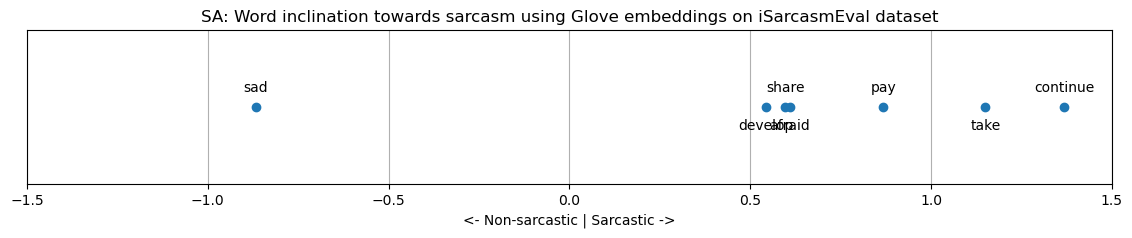

In [101]:
# Plotting the examples
import matplotlib.pyplot as plt

# Preparing data
# sarcasm_evaluations = [semantic_model.word_sentiment(word) for word in sample_words]
# scores = [res[1] for res in sarcasm_evaluations]
scores = [semantic_axis[word] for word in sample_words]
print(np.argsort(scores))
rearr_sample_words = [sample_words[idx] for idx in np.argsort(scores)]
rearr_scores = sorted(scores)
y = [0] * len(scores)
z = [0.10 if i%2==0 else -0.15 for i in range(len(scores))]
# print(len(scores), len(sample_words), len(y), len(z))
print(scores)

# Creating the plot
plt.figure(figsize=(14,2))
# plt.xscale('log')
extreme = int(max(np.abs(scores))) + 0.5
plt.xlim(-extreme,extreme)
plt.xlabel('<- Non-sarcastic | Sarcastic ->')
plt.scatter(rearr_scores, y)
plt.yticks([])
# plt.xticks(scores, labels= sample_words)
plt.ylim(-0.5,0.5)
plt.title('SA: Word inclination towards sarcasm using ' + model_name + ' embeddings on ' + dataset + ' dataset')

for i, word in enumerate(rearr_sample_words):
    plt.annotate(word, (rearr_scores[i], z[i]), ha='center')
plt.grid()
plt.savefig('../outputs/'+"_".join([dataset, model_name, 'semantic_axis'])+'.png', bbox_inches='tight')
plt.show()

### Sentence classification

In [102]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# def remove_contractions(doc):
#     return " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in doc.split()])

def lemmatize_text(doc):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(doc)]
    #spacy alternative
    #return [j.lemma_ for token in doc for j in nlp(token)]

def remove_stops(doc) -> list:
    # Filter out stop words by using the stop_words attribute
    return [token for token in doc if token not in stop_words]
    #spacy alternative
    #return [token.text for token in doc if not token.is_stop]

In [103]:
from config import Config
from pathlib import Path
import pandas as pd
# ['Reddit', 'iSarcasm']
# cfg = Config('iSarcasmEval')
assert Path(cfg.test_file_path).exists, f"File not found {cfg.test_file_path}"
test = pd.read_csv(cfg.test_file_path)
print(test.size)
test.head()


2800


,text,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0


In [104]:
# test["remove_contractions"] = test['text'].apply(remove_contractions)
test['text_lemmatized'] = test.text.apply(lemmatize_text)
# apply removing stop words to all
test['removed_stop_words'] = test.text_lemmatized.apply(remove_stops)

In [105]:
test_x = test['removed_stop_words'].tolist()
test_y = test['sarcastic'].tolist()
# print(type(test_x), type(test_x[0]), type(test_y[0]))
# print(len(test_x), len(test_y))
pred_y = []
for example in test_x:
    # print(example)
    sentence_embedding = np.zeros(model.get_vector('word').shape)
    i = 0
    for word in example:
        try:
            # print(word)
            sentence_embedding += model.get_vector(word)
            i += 1
        except KeyError:
            continue
    if i>0:
        sentence_embedding = sentence_embedding/(i+1)
    _, score = semantic_model.vector_sentiment(sentence_embedding)
    pred = 1 if score else 0
    pred_y.append(pred)
print(len(pred_y))

1400


C:\Users\omars\AppData\Local\Temp\ipykernel_6812\4128143041.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [106]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

acc = accuracy_score(test_y, pred_y)
# pre = accuracy_score(test_y, pred_y)
# rec = accuracy_score(test_y, pred_y)
f1 = f1_score(test_y, pred_y)
print(f"accuracy: {acc}, f1-score: {f1}")

accuracy: 0.14285714285714285, f1-score: 0.25


### Sentiment Propagation

In [14]:
class SentimentPropagation:
    """
    Sentiment Propagation according to Hamilton et al (2016)
    https://doi.org/10.18653/v1/D16-1057
    """
    
    def __init__(self, words, model): #embedding_dict: Dict[str, np.ndarray])
        """
        Args:
            words       List of keywords extracted from the dataset
            model       Gensim Word embedding model
        """
        self.word_index = dict()
        self.index_word = dict()
        self.embeddings = list()
        self.model = model
        self.words = words
        # for idx, item in enumerate(embedding_dict.items()):
        #     token, embedding = item
        #     self.embeddings.append(embedding)
        #     self.word_index[token] = idx
        
        # Create embedding list and word_index dict
        remove_list = []
        idx_corr = 0
        for idx, word in enumerate(self.words):
            try:
                self.embeddings.append(self.model[word])
                self.word_index[word] = idx - idx_corr
            except KeyError:
                idx_corr += 1
                remove_list.append(word)
                continue
        
        # Remove words without embeddings
        for del_word in remove_list:
            self.words.remove(del_word)

        self.embeddings = np.stack(self.embeddings)
        self.vocab_size = len(self.word_index)

        
    def edge_matrix(self, n_neighbors:int=10) -> np.ndarray:
        """
        Construct the graph edge matrix where:
        E[i, j] = arccos(-(w[i].T @ w[j]) / (norm(w[i]) * norm(w[j])))
        
        Args:
            n_neighbors (int) - The number of neighbors each vertex in the graph has
        Returns:
            (np.ndarray)      - The edge matrix
        """
        product = self.embeddings @ self.embeddings.T
        normed = np.linalg.norm(self.embeddings, axis=1).reshape(-1, 1)
        norm_product = normed @ normed.T
        arg = (product / norm_product)
        np.fill_diagonal(arg, 0)
        for idx, row in enumerate(arg):
            arg[idx, np.argsort(row)[:-20]] = 0
        return np.arccos(-arg.clip(-1, 1))
    
    def transition_matrix(self, edge_matrix: np.ndarray) -> np.ndarray:
        """
        Construct the transition matrix T from the edge matrix
        
        In contrast to the paper we use 1/s here (maybe an error in the paper?)
        
        Args:
            edge_matrix (np.ndarray) - edge_matrix
        Returns:
            (np.ndarray)             - The transition matrix
        """
        diag = np.diag([1/s if s > 0 else 0 for s in edge_matrix.sum(axis=0)])**(1/2)
        return diag @ edge_matrix @ diag
    
    def run(self, 
            T: np.ndarray, s: np.ndarray, p: np.ndarray, 
            beta: float, eps: float, max_iter: int) -> np.ndarray:
        """
        Update p until convergence
        
        Args:
            T (np.ndarray) - Transition matrix
            s (np.ndarray) - Seed vector
            p (np.ndarray) - Word-Sentiment vector
            beta (float)   - Local consistency vs. global consistency
            eps (float)    - Convergence criterium
            max_iter (int) - Convergence criterium
        Returns:
            p (np.ndarray) - Learned word-sentiment vector
        """
        for i in range(max_iter):
            new_p = (beta * T @ p + (1 - beta) * s)
            if np.abs(new_p - p).sum() < eps:
                break
            p = new_p
        return p
    
    def fit(self, 
              positive_seeds: List[str],
              negative_seeds: List[str], 
              beta: float=0.1, 
              n_neighbors: int=10, 
              eps:float=1e-9,
              max_iter:int=1000) -> Dict[str, float]:
        """
        Learn sentiment scores
        
        Args:
            positive_seeds (List[str]) - A list of positive seed words (sarcastic)
            negative_seeds (List[str]) - A list of negative seed words (non-sarcastic)
            beta (float)               - Local consistency vs. global consistency
            n_neighbors (int)          - The number of neighbors each vertex in the graph has
            eps (float)                - Convergence criterium
            max_iter (int)             - Convergence criterium
        Returns:
            (Dict[str, float])         - A dictionary containing the learned sentiment scores
                                         with zero mean and unit variance
        """
        T = self.transition_matrix(self.edge_matrix(n_neighbors))
        
        s_positive = np.zeros(self.vocab_size)
        s_negative = np.zeros(self.vocab_size)
        
        s_positive[[self.word_index[seed] for seed in positive_seeds]] = 1 / len(positive_seeds)
        s_negative[[self.word_index[seed] for seed in negative_seeds]] = 1 / len(negative_seeds)
        
        p_positive = self.run(
            T, s_positive.reshape(-1, 1), 
            np.ones((self.vocab_size, 1)) / self.vocab_size, 
            beta, eps, max_iter
        )
        p_negative = self.run(
            T, s_negative.reshape(-1, 1),
            np.ones((self.vocab_size, 1)) / self.vocab_size,
            beta, eps, max_iter
        )
        
        score = p_positive / (p_positive + p_negative)
        # Make sure scores have zero mean and unit variance
        score = score - np.mean(score)
        score = score / np.std(score)
        
        # Construct dictionary
        sentiment = dict()
        for token, idx in self.word_index.items():
            sentiment[token] = score[idx].item()
            
        return sentiment

In [15]:
print(f"Creating sentiment propagation model using {model_name} embeddings")
if dataset == 'Reddit':
    sentiment_model = SentimentPropagation(sorted_words, model)
    sentiment_prop = sentiment_model.fit(sarcastic_seeds, non_sarcastic_seeds, beta=0.1, n_neighbors=10, eps=1e-10, max_iter=10000)
else:
    sentiment_model = SentimentPropagation(sorted_words, model)
    sentiment_prop = sentiment_model.fit(sarcastic_seeds, non_sarcastic_seeds, beta=0.1, n_neighbors=10, eps=1e-9, max_iter=100000)

Creating sentiment propagation model using Word2Vec embeddings


In [16]:
# print(len(sentiment_prop))
# pprint(sentiment_prop)
# sarcasm_evaluations = [sentiment_prop[word] for word in sample_words]
# print(sample_words, sarcasm_evaluations)

[0 3 1 2 5 4 6]


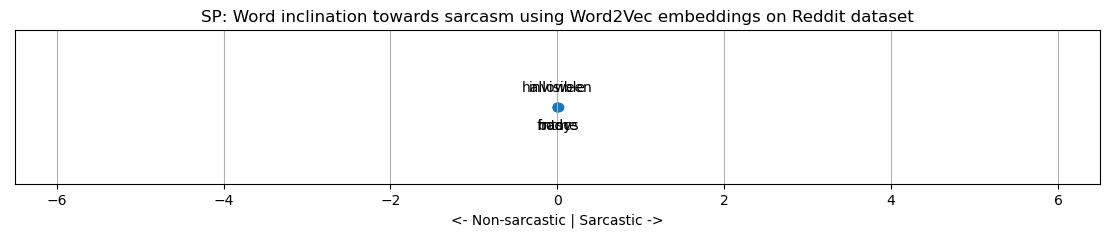

In [17]:
# Plotting the examples
import matplotlib.pyplot as plt
# sarcasm_evaluations = [sentiment_model.word_sentiment(word) for word in sample_words]
# scores = [res[1] for res in sarcasm_evaluations]
scores = [sentiment_prop[word] for word in sample_words]

print(np.argsort(scores))
rearr_sample_words = [sample_words[idx] for idx in np.argsort(scores)]
rearr_scores = sorted(scores)
y = [0] * len(scores)
z = [0.10 if i%2==0 else -0.15 for i in range(len(scores))]

# Creating the plot
plt.figure(figsize=(14,2))
# plt.xscale('log')
extreme = int(max(np.abs(scores))) + 0.5
plt.xlim(-extreme,extreme)
plt.xlabel('<- Non-sarcastic | Sarcastic ->')
plt.scatter(rearr_scores, y)
plt.yticks([])
# plt.xticks(scores, labels= sample_words)
plt.ylim(-0.5,0.5)
plt.title('SP: Word inclination towards sarcasm using ' + model_name + ' embeddings on ' + dataset + ' dataset')

for i, word in enumerate(rearr_sample_words):
    plt.annotate(word, (rearr_scores[i], z[i]), ha='center')
plt.grid()
plt.savefig('../outputs/'+"_".join([dataset, model_name, 'sentiment_prop'])+'.pdf', bbox_inches='tight')
plt.show()

In [18]:
print(len(sentiment_prop))
# sentiment_prop.values()

8977


c:\Users\omars\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\omars\miniconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


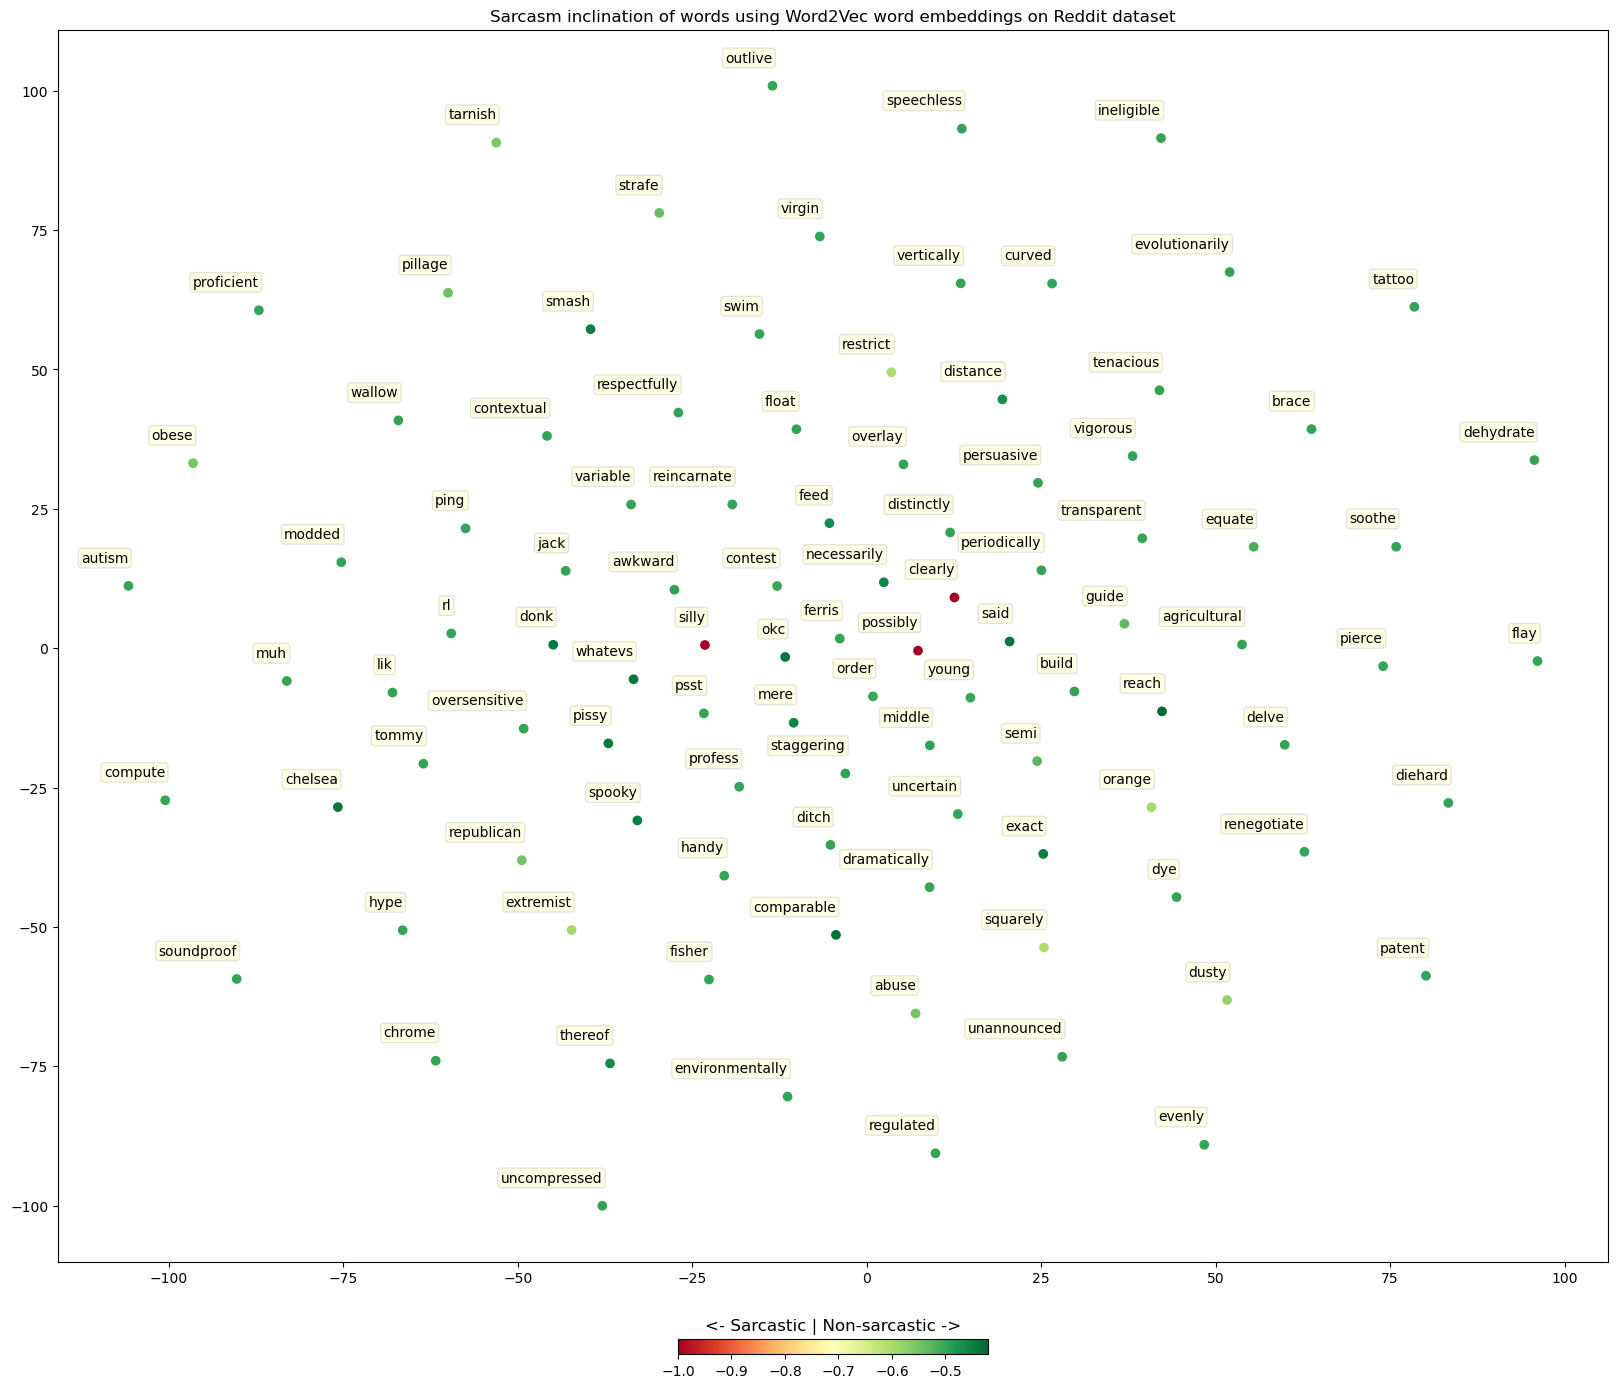

In [19]:
from sklearn.manifold import TSNE
import random

if dataset == 'Reddit':
    n_samples = 500
    # Sample random words from model dictionary
    random_i = random.sample(range(len(sentiment_prop)), n_samples)
    random_w = [list(sentiment_prop.keys())[i] for i in random_i]
else:
    n_samples = 395
    random_i = np.arange(0,395)
    random_w = [list(sentiment_prop.keys())[i] for i in random_i]

# Override
n_samples = 100
random_i = random.sample(range(len(sentiment_prop)), n_samples)
random_w = [list(sentiment_prop.keys())[i] for i in random_i]

# Generate word embeddings of each word
word_vecs = np.array([model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

def sigmoid(z):
    return 1/(1 + np.exp(-20*z))

color = [sigmoid(sentiment_prop[w])*(-1) for w in random_w]

# Plot t-SNE result
plt.figure(figsize=(20, 20))
# plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=color, cmap=plt.get_cmap('RdYlGn'))

# Decorating the plot
plt.title('Sarcasm inclination of words using ' + model_name + ' word embeddings on ' + dataset + ' dataset')
clb = plt.colorbar(location='bottom', orientation='horizontal', shrink = 0.2, pad = 0.05)
# clb.ax.set_title('<- Non-sarcastic | Sarcastic ->')
clb.ax.set_title('<- Sarcastic | Non-sarcastic ->')


for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))
plt.savefig('../outputs/'+"_".join([dataset, model_name, 'sentiment_prop_TSNE'])+'.pdf', bbox_inches='tight')

Pearson Correlation

In [20]:
def pearson(sentimentA, sentimentB):
    common_terms = set(sentimentA.keys()).intersection(set(sentimentB.keys()))
    sentiment_scoresA = [sentimentA[term] for term in common_terms]
    sentiment_scoresB = [sentimentB[term] for term in common_terms]

    return np.corrcoef(sentiment_scoresA, sentiment_scoresB)
    
pearson(semantic_axis, sentiment_prop)

array([[1.        , 0.15350791],
       [0.15350791, 1.        ]])